In [ ]:
#Version of this tensorflow only exist in Colab book
try:
  %tensorflow_version 2.x
except Exception:
  pass

Image classification models have millions of parameters. Training them from scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.
This Colab demonstrates how to build a Keras model for classifying of flags by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. 

Import Tensorflow Library


In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

#print("TF version:", tf.__version__)
#print("Hub version:", hub.__version__)
#print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.5.0
Hub version: 0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


For starters, use https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4. The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. 
(Note: hub.Modules for TF 1.x won't work here.)

mobileNet V2 is a neural network architectures for efficient on device image classification and related tasks.

In [ ]:

module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
#URL can be used in code to identify the SavedModel and in your browser to show its documentation
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


Inputs are suitably resized for the selected module. Dataset augmentation improves training.

Mount Flags Dataset from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train dataset from flags dataset

In [ ]:
data_dir='/content/drive/MyDrive/flags/train'

Show the layers present in Dataset.

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE,
                       batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator( **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir,
     subset="validation", 
     shuffle=False, **dataflow_kwargs)

do_data_augmentation = True 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 87 images belonging to 3 classes.
Found 355 images belonging to 3 classes.


All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.
For speed, we start out with a non-trainable feature_extractor_layer.

In [ ]:
do_fine_tuning = False

It put a linear classifier on top of the feature extractor layer with the Hub.
For speed, use non-trainable feature extractor layer, but we can also enable fine tuning for greater accuracy.

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_8 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


Training the model

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit_generator(
    train_generator,
    epochs=10, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

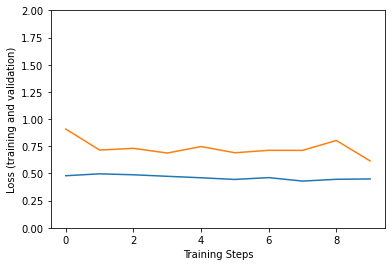

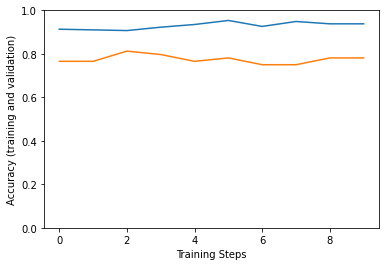

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

The trained model can be saved for deployment to TF Serving or TF Lite (on mobile, Android, iOS) as follows.

Trained model saved for deployment to Serving or TF Lite.

In [ ]:
saved_model_path = "saved_model/flagmodel"
!mkdir -p saved_model
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: saved_model/flagmodel/assets


INFO:tensorflow:Assets written to: saved_model/flagmodel/assets


Deployment to TensorFlow Lite:

TensorFlow Lite lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TF Lite and apply post-training tools from the TensorFlow Model Optimization Toolkit. Finally, it runs it in the TF Lite Interpreter to examine the resulting quality
Converting without optimization provides the same results as before (up to roundoff error).
Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range.


Create TFLite model file path in drive.

In [ ]:
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/flag.tflite"

mkdir: cannot create directory ‘tflite_models’: File exists


Deployment to TensorFlow Lite: Post Training quantization to 8-bit integers.

In [ ]:
model = tf.saved_model.load(saved_model_path)
concrete_func = model.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 224, 224, 3])
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

8968016

In [ ]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)
['Canada' 'France' 'Germany']
